torch.Size([1, 3, 574, 700])
(1, 574, 700)
torch.Size([574, 700])


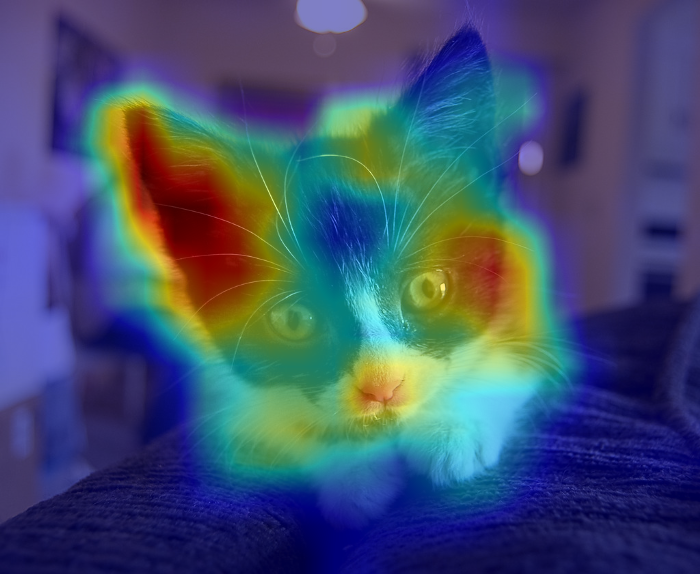

In [1]:
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
from PIL import Image
import torchvision
import torch


model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

path = '../data/GradCAM/cat.jpg'
image = np.array(Image.open(path))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create an input tensor image for your model..
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)
print(input_tensor.shape)

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(grayscale_cam.shape)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]


mask = torch.tensor(grayscale_cam < 0.85, dtype=torch.int)
print(mask.shape)
masked_inputs = torch.multiply(input_tensor, mask)

distracted_cam = cam(input_tensor=masked_inputs, targets=targets)
distracted_cam = distracted_cam[0, :]



visualization = show_cam_on_image(image/255, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)


tensor([[[[0.6627, 0.6667, 0.6667,  ..., 0.5490, 0.5608, 0.5725],
          [0.6706, 0.6706, 0.6745,  ..., 0.5686, 0.5725, 0.5843],
          [0.6706, 0.6706, 0.6745,  ..., 0.5725, 0.5765, 0.5843],
          ...,
          [0.1098, 0.1098, 0.1098,  ..., 0.1922, 0.1882, 0.1882],
          [0.0980, 0.0941, 0.0902,  ..., 0.1922, 0.1882, 0.1882],
          [0.0824, 0.0824, 0.0784,  ..., 0.1922, 0.1882, 0.1882]],

         [[0.5333, 0.5373, 0.5412,  ..., 0.4784, 0.4863, 0.4863],
          [0.5412, 0.5451, 0.5490,  ..., 0.4980, 0.4980, 0.4980],
          [0.5412, 0.5412, 0.5490,  ..., 0.5020, 0.4980, 0.4980],
          ...,
          [0.0941, 0.0941, 0.0941,  ..., 0.1882, 0.1843, 0.1843],
          [0.0824, 0.0784, 0.0745,  ..., 0.1882, 0.1843, 0.1843],
          [0.0667, 0.0667, 0.0627,  ..., 0.1922, 0.1882, 0.1882]],

         [[0.3569, 0.3608, 0.3569,  ..., 0.3255, 0.3216, 0.3216],
          [0.3647, 0.3647, 0.3647,  ..., 0.3412, 0.3333, 0.3333],
          [0.3647, 0.3647, 0.3608,  ..., 0

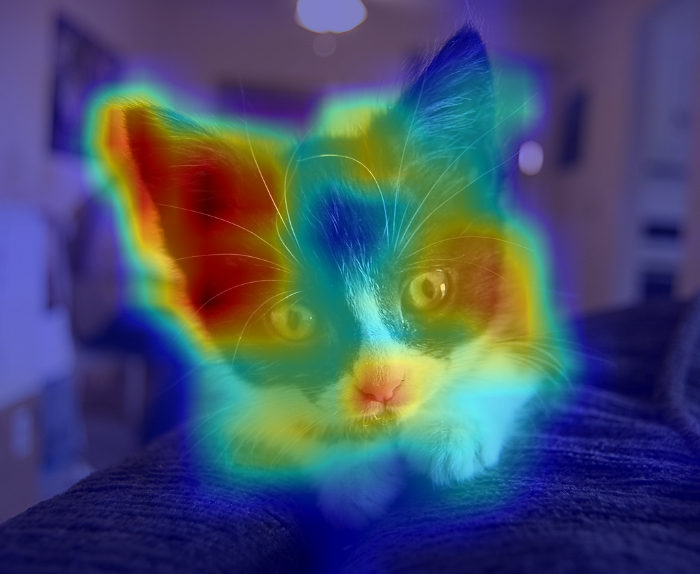

In [2]:
distracted_visualization = show_cam_on_image(image/255, distracted_cam, use_rgb=True)
print(distracted_visualization.shape)
Image.fromarray(distracted_visualization)

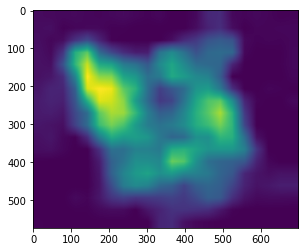

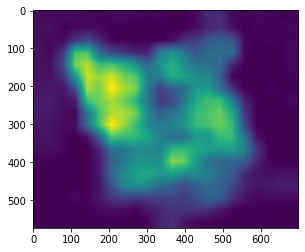

In [3]:
import matplotlib.pyplot as plt
print()
g_img = np.asarray(Image.open(path).convert('L'))
plt.imshow(grayscale_cam[:])
plt.show()
g_img = np.asarray(Image.open(path).convert('L'))
plt.imshow(distracted_cam[:])
plt.show()

In [4]:

def cam_mean_kurtosis(cam_batch):
    deviations = cam_batch - np.mean(cam_batch, (-1, -2))[:, :, None, None]
    squared_squared_deviations = np.square(np.square(deviations))
    print(np.mean(squared_squared_deviations))
    std_devs = np.std(cam_batch, (-1, -2))[:, :, None, None]
    print(std_devs)
    scaled_squared_squared_deviations = np.divide(squared_squared_deviations, np.power(std_devs,4))
    return np.mean(scaled_squared_squared_deviations)
print(cam_mean_kurtosis(grayscale_cam[None,None, :]))
print(cam_mean_kurtosis(distracted_cam[None,None, :]))

0.011022095
[[[[0.2457663]]]]
3.0211687
0.011889335
[[[[0.25823992]]]]
2.6734006


/tmp/ipykernel_31716/1404959284.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  smoothed_input = torch.tensor(smoothed_input*255, dtype=torch.uint8)


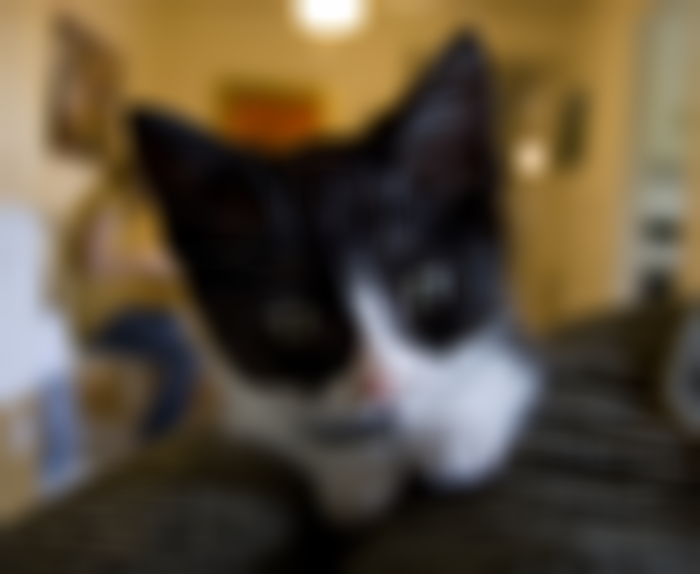

In [15]:
SCALE = 15
KERNEL_SIZE = 2*SCALE + 1
gaussian_filter = torchvision.transforms.GaussianBlur(KERNEL_SIZE, SCALE)
smoothed_input = gaussian_filter(input_tensor)[0]
smoothed_input = smoothed_input.transpose(-1,-3).transpose(-2, -3)
smoothed_input = torch.tensor(smoothed_input*255, dtype=torch.uint8)
Image.fromarray(smoothed_input.numpy())